In [1]:
import sys
import os
import shutil
import time
import importlib

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from random import randint
from types import SimpleNamespace

In [4]:
from utils import compressor
from utils import decompressor
from utils import image_utils
from utils import network_utils
from utils import compression_utils
from utils import glob

In [5]:
# In caso di modifiche ai sorgenti 
importlib.reload(image_utils)
importlib.reload(network_utils)
importlib.reload(compression_utils)
importlib.reload(glob)

<module 'utils.glob' from 'C:\\Users\\thefo\\CompressioneDati\\utils\\glob.py'>

In [6]:
autoencoder = tf.keras.models.load_model('modello.h5')

In [7]:
encoder, decoder = network_utils.get_trained_encoder_decoder(autoencoder, n_layers=6)

In [10]:
#Testo tutto il funzionamento.
compression_code=compressor.compress("dataset2_preloaded/valid/lena.png", encoder, decoder, 5)
decompressor.decompress(compression_code, decoder)

Compressor STARTS


FileNotFoundError: [Errno 2] No such file or directory: 'dataset2_preloaded/valid/lena.png'

In [8]:
images = [image_utils.load_image("dataset2_preloaded/valid/lena.png")[0],
          image_utils.load_image("dataset2_preloaded/valid/parrots.png")[0],
          image_utils.load_image("dataset2_preloaded/valid/mandrill.png")[0]]

In [9]:
image_paths = ["dataset2_preloaded/valid/lena.png", "dataset2_preloaded/valid/parrots.png", "dataset2_preloaded/valid/mandrill.png"]

In [14]:
#psnrs=[[], [], []]
#compression_ratios= [[], [], []]
for i in range(1, 101):
    for idx, image in enumerate(images):
         compression_utils.compressor(image_paths[idx], encoder, decoder, i, False)
        time.sleep(0.250)
        decompressed = image_utils.load_image("predicted/decompression.png")[0]
        psnrs[idx].append(image_utils.get_psnr(image, decompressed))
        compression_ratios[idx].append(compression_utils.evaluate_compression_ratio(image_paths[idx], encoder, decoder,i, False))
    print(i)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


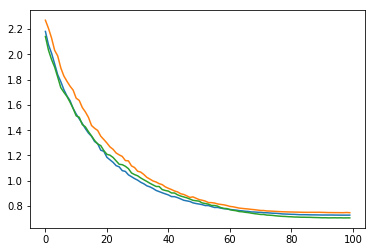

In [19]:
plt.plot(np.asarray(compression_ratios[0]))
plt.plot(np.asarray(compression_ratios[1]))
plt.plot(np.asarray(compression_ratios[2]))

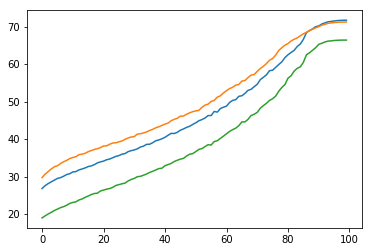

In [24]:
plt.plot(np.asarray(psnrs[0]))
plt.plot(np.asarray(psnrs[1]))
plt.plot(np.asarray(psnrs[2]))

In [11]:
compression_utils.evaluate_compression_ratio("dataset2_preloaded/valid/lena.png", encoder, decoder,23)

Elapsed: 0.010583386999996947
Elapsed: 0.012103965000001438
Metodo test_blocks, test_block.shape (36, 128, 128, 3)
Elapsed: 0.004998166999996556
Elapsed: 0.07830770700000045
image_blocks_size 7077888 compressed_blocks_comp 1383614
Elapsed: 0.9978615269999977
T elapsed = 0.0028488989999999603
T elapsed = 0.003971082999996156
Fine calcolo errore T elapsed = 0.05008037300000012
Shape important errors (117637, 5)
[[ 3.13692689e-02  5.96482754e-02 -1.99371278e-02  2.00000000e+00
   5.00000000e+00]
 [ 3.57396603e-02  6.15128279e-02  9.89735126e-05  2.00000000e+00
   7.00000000e+00]
 [ 3.39536667e-02  2.98479199e-02 -1.46571100e-02  2.00000000e+00
   8.00000000e+00]
 ...
 [-2.54780054e-02  1.79781839e-02 -7.78642595e-02  5.10000000e+02
   1.46000000e+02]
 [-1.13149285e-02  5.91811538e-03 -4.85455394e-02  5.10000000e+02
   1.64000000e+02]
 [ 9.05603170e-04  2.85083279e-02 -3.14459354e-02  5.10000000e+02
   4.91000000e+02]]
Fine evaluate error Elapsed: 0.09194252999999719
shape compressed_block

1.1569293778079845